In [ ]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/f5/b6/653a70910739f127adffbefb688ebc22b51139292757de7c22b1e04ce792/xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.7 MB/s eta 0:00:0000:0100:01


In [37]:
#Required Imports
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import hvplot.pandas

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, make_scorer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [47]:
train_df = pd.read_csv("data/processed/train_data.csv")
test_df = pd.read_csv("data/processed/test_data.csv")

In [48]:
X_cols = train_df.drop(columns = ["loan_status"]).columns
y_col = ["loan_status"]

In [49]:
X_train = train_df[X_cols]
X_test = test_df[X_cols]
y_train = train_df[y_col]
y_test = test_df[y_col]

In [50]:
X_train.head()

,loan_amnt,int_rate,installment,sub_grade,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,...,grade,emp_title,home_ownership,verification_status,purpose,title,zip_code,addr_state,initial_list_status,application_type
0,10000.0,6.08,304.59,2,10.0,85000.0,21.91,18.0,0.0,9644.0,...,A,NaN,MORTGAGE,Not Verified,other,Other,405xx,KY,f,Individual
1,5000.0,7.26,154.99,4,3.0,43000.0,17.11,9.0,0.0,4715.0,...,A,Health and Benefits Administrator,RENT,Source Verified,debt_consolidation,Debt consolidation,021xx,MA,w,Individual
2,10000.0,12.99,336.90,5,6.0,45000.0,10.98,6.0,0.0,7659.0,...,B,Supervisor,RENT,Source Verified,debt_consolidation,Debt consolidation,462xx,IN,w,Individual
3,4000.0,13.33,135.42,3,6.0,48000.0,1.75,5.0,1.0,539.0,...,C,purchasing Agent,RENT,Not Verified,debt_consolidation,Debt consolidation,073xx,NJ,w,Individual
4,24000.0,14.49,564.56,4,0.5,110000.0,7.65,18.0,0.0,25019.0,...,C,Underwriter,MORTGAGE,Verified,credit_card,Credit card refinancing,115xx,NY,f,Individual


In [51]:
numerical_cols = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=['number']).columns.tolist()

In [52]:
X_train[categorical_cols].head()

,grade,emp_title,home_ownership,verification_status,purpose,title,zip_code,addr_state,initial_list_status,application_type
0,A,NaN,MORTGAGE,Not Verified,other,Other,405xx,KY,f,Individual
1,A,Health and Benefits Administrator,RENT,Source Verified,debt_consolidation,Debt consolidation,021xx,MA,w,Individual
2,B,Supervisor,RENT,Source Verified,debt_consolidation,Debt consolidation,462xx,IN,w,Individual
3,C,purchasing Agent,RENT,Not Verified,debt_consolidation,Debt consolidation,073xx,NJ,w,Individual
4,C,Underwriter,MORTGAGE,Verified,credit_card,Credit card refinancing,115xx,NY,f,Individual


# Oversampling

In [6]:
from sklearn.utils import resample
#Upsample the minority class (Random Oversampling)

#Separate majority and minority classes
majority_class = train_df[train_df['loan_status'] == 1]  # Fully Paid (1)
minority_class = train_df[train_df['loan_status'] == 0]  # Charged Off (0)

#Upsample minority class
minority_class_upsampled = resample(
    minority_class, 
    replace=True,     
    n_samples=int(len(majority_class)/2), 
    random_state=42
)

train_df_balanced = pd.concat([majority_class, minority_class_upsampled])
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_balanced = train_df_balanced.drop(columns=['loan_status'])
y_train_balanced = train_df_balanced['loan_status']

In [7]:
#Verification Point - We have converted it to 2:1 ratio
y_train_balanced.value_counts()

loan_status
1    1570803
0     785401
Name: count, dtype: int64

In [8]:
numerical_cols = X_train_balanced.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_train_balanced.select_dtypes(exclude=['number']).columns.tolist()

# Pipeline

In [9]:
def create_pipeline(numerical_cols, categorical_cols, classifier = None, gridcv = None):
    # Define preprocessing steps
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  #Impute missing values with median (Right Skewed numerical features)
        ('scaler', StandardScaler())  # Standard Scaling
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  #Fill missing categorical values with "missing"
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  #OneHotEncoding
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    # Define the pipeline with preprocessing + model/grid
    if classifier:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', classifier)
        ])
    elif gridcv:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('grid_search', gridcv)
        ])
    else:
        return "Error. Provide a classifier or grid serach instance"

    return pipeline

In [10]:
#Model Evaluation
def evaluate_model(model, model_name, train_combined, y_train, test_combined, y_test):
    def calculate_metrics(predictions, probabilities, y_true):
        accuracy = accuracy_score(y_true, predictions)
        precision = precision_score(y_true, predictions)
        recall = recall_score(y_true, predictions)
        f1 = f1_score(y_true, predictions)
        roc_auc = roc_auc_score(y_true, probabilities)
        return accuracy, precision, recall, f1, roc_auc

    def print_metrics(accuracy, precision, recall, f1, roc_auc, dataset_name):
        print(f"\n{dataset_name} Set Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

    def plot_confusion_matrix(y_true, predictions, dataset_name):
        conf_matrix = confusion_matrix(y_true, predictions)
        plt.figure(figsize=(7, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
                    xticklabels=['Class 0', 'Class 1'],
                    yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix ({dataset_name} Set')
        plt.show()

    def plot_roc_curve(y_true, probabilities, dataset_name):
        fpr, tpr, _ = roc_curve(y_true, probabilities)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve ({dataset_name} Set')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def print_classification_report(y_true, predictions, dataset_name):
        report = classification_report(y_true, predictions, target_names=['Class 0', 'Class 1'])
        print(f"Classification Report ({dataset_name} Set:\n", report)

    # Print the model name for reference
    print(f"\n=== Evaluation Results for {model_name}===")

    # Test set evaluation
    test_probabilities = model.predict_proba(test_combined)[:, 1]
    test_predictions = (test_probabilities >= 0.5).astype(int)
    test_metrics = calculate_metrics(test_predictions, test_probabilities, y_test)
    print_metrics(*test_metrics, "Test")
    plot_confusion_matrix(y_test, test_predictions, "Test")
    plot_roc_curve(y_test, test_probabilities, "Test")
    print_classification_report(y_test, test_predictions, "Test")

## LGBM default

In [ ]:
classifier = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
pipeline = create_pipeline(numerical_cols, categorical_cols, classifier = classifier)
pipeline.fit(X_train_balanced, y_train_balanced)
pipeline

[LightGBM] [Info] Number of positive: 1570803, number of negative: 785401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163082
[LightGBM] [Info] Number of data points in the train set: 2356204, number of used features: 80555
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666667 -> initscore=0.693148
[LightGBM] [Info] Start training from score 0.693148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'annual_inc',
                                                   'dti', 'open_acc', 'pub_rec',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'mort_acc',
                                                   'pub_rec_bankruptcies']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Sim...ng',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'grade', 'sub_grade',
                                                   'emp_title', 'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'purpose', 'title',
                                                   'zip_code', 'addr_state',
                                                   'earliest_cr_line',
                                                   'initial_list_status',
                                                   'application_type'])])),
                ('model',
                 LGBMClassifier(max_depth=6, n_estimators=200,
                                random_state=42))])


=== Evaluation Results for XGBoost Model===

Test Set Metrics:
Accuracy: 0.8227
Precision: 0.9002
Recall: 0.8954
F1 Score: 0.8978
ROC AUC: 0.7387


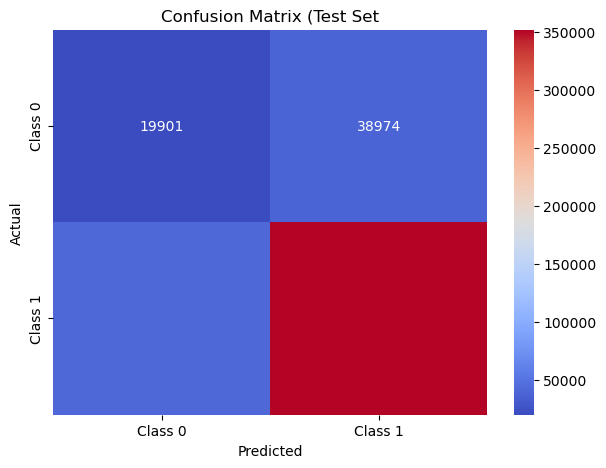

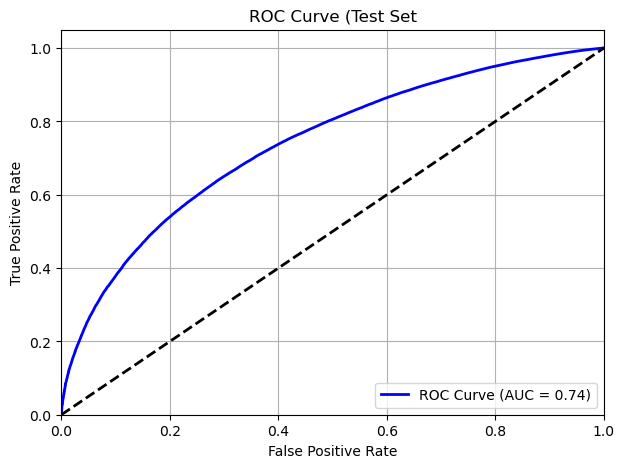

Classification Report (Test Set:
               precision    recall  f1-score   support

     Class 0       0.33      0.34      0.33     58875
     Class 1       0.90      0.90      0.90    392701

    accuracy                           0.82    451576
   macro avg       0.61      0.62      0.61    451576
weighted avg       0.83      0.82      0.82    451576



In [17]:
#Model Evaluation
evaluate_model(
    model=pipeline,
    model_name="LGBM Model",
    train_combined=X_train_balanced,
    y_train=y_train_balanced,
    test_combined=X_test,
    y_test=y_test
)

## LGBM hyperparameter tuning

In [23]:
parameter_grid = {
                  "learning_rate": [0.1, 0.01],
                  "n_estimators": [100, 250, 500],
                  "reg_lambda": [0, 0.1, 0.01]
                  }

In [13]:
def recall_for_class(y_true, y_pred, labels=None, pos_label=1):
    return recall_score(y_true, y_pred, labels=labels, pos_label=pos_label)

def create_recall_scorer(pos_label=1):
  return make_scorer(recall_for_class, pos_label=pos_label)


In [25]:
grid = GridSearchCV(estimator=LGBMClassifier(), param_grid=parameter_grid, scoring=create_recall_scorer(pos_label=0))

In [26]:
pipeline = create_pipeline(numerical_cols, categorical_cols, gridcv = grid)
pipeline.fit(X_train_balanced, y_train_balanced)
pipeline

[LightGBM] [Info] Number of positive: 1256642, number of negative: 628321
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 15.433016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37293
[LightGBM] [Info] Number of data points in the train set: 1884963, number of used features: 17659
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666667 -> initscore=0.693147
[LightGBM] [Info] Start training from score 0.693147
[LightGBM] [Info] Number of positive: 1256642, number of negative: 628321
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 15.105429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37137
[LightGBM] [Info] Number of data points in the train set: 1884963, number of used features: 17581


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'annual_inc',
                                                   'dti', 'open_acc', 'pub_rec',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'mort_acc',
                                                   'pub_rec_bankruptcies']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Sim...
                                                   'verification_status',
                                                   'purpose', 'title',
                                                   'zip_code', 'addr_state',
                                                   'earliest_cr_line',
                                                   'initial_list_status',
                                                   'application_type'])])),
                ('grid_search',
                 GridSearchCV(estimator=LGBMClassifier(),
                              param_grid={'learning_rate': [0.1, 0.01],
                                          'n_estimators': [100, 250, 500],
                                          'reg_lambda': [0, 0.1, 0.01]},
                              scoring=make_scorer(recall_for_class, response_method='predict', pos_label=0)))])

In [27]:
print("DONE BITCH")

DONE BITCH


In [31]:
best_params = pipeline.named_steps["grid_search"].best_params_


=== Evaluation Results for LGBM Model===

Test Set Metrics:
Accuracy: 0.8192
Precision: 0.9022
Recall: 0.8884
F1 Score: 0.8952
ROC AUC: 0.7448


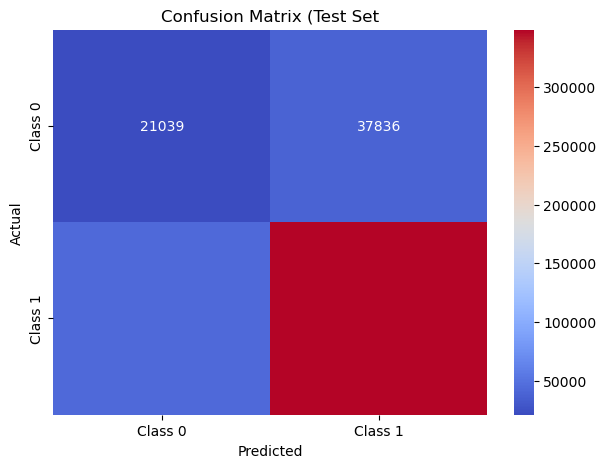

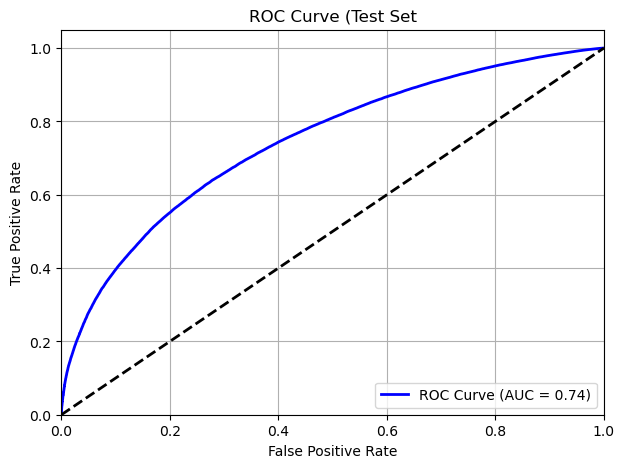

Classification Report (Test Set:
               precision    recall  f1-score   support

     Class 0       0.32      0.36      0.34     58875
     Class 1       0.90      0.89      0.90    392701

    accuracy                           0.82    451576
   macro avg       0.61      0.62      0.62    451576
weighted avg       0.83      0.82      0.82    451576



In [32]:
#Model Evaluation
evaluate_model(
    model=pipeline,
    model_name="LGBM Model",
    train_combined=X_train_balanced,
    y_train=y_train_balanced,
    test_combined=X_test,
    y_test=y_test
)

## XGBoost

In [35]:
# classifier = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
pipeline = create_pipeline(numerical_cols, categorical_cols, classifier = XGBClassifier(random_state=100))
pipeline.fit(X_train_balanced, y_train_balanced)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'annual_inc',
                                                   'dti', 'open_acc', 'pub_rec',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'mort_acc',
                                                   'pub_rec_bankruptcies']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Sim...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=100, ...))])


=== Evaluation Results for LGBM Model===

Test Set Metrics:
Accuracy: 0.8182
Precision: 0.9013
Recall: 0.8881
F1 Score: 0.8947
ROC AUC: 0.7402


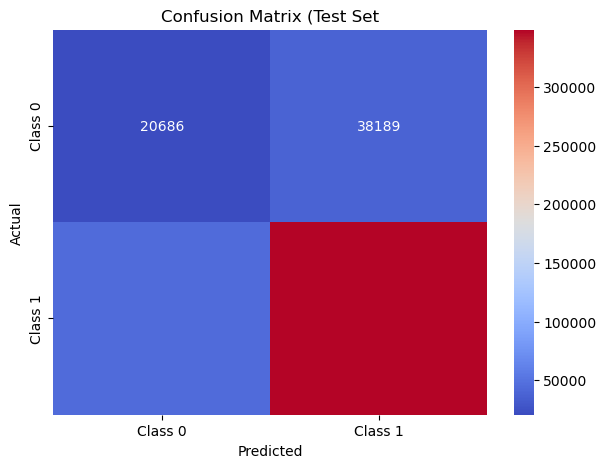

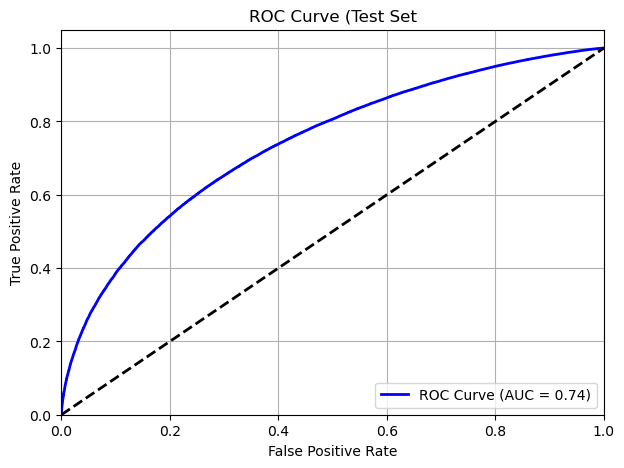

Classification Report (Test Set:
               precision    recall  f1-score   support

     Class 0       0.32      0.35      0.34     58875
     Class 1       0.90      0.89      0.89    392701

    accuracy                           0.82    451576
   macro avg       0.61      0.62      0.61    451576
weighted avg       0.83      0.82      0.82    451576



In [36]:
#Model Evaluation
evaluate_model(
    model=pipeline,
    model_name="LGBM Model",
    train_combined=X_train_balanced,
    y_train=y_train_balanced,
    test_combined=X_test,
    y_test=y_test
)